# Botnet Logistic Regression Classifier - Parallelized Version

Parallelized version of readFile, normalize, train and accuracy functions. The algorithm converges during training, the cost value decreases asymptotically at each iteration. The final reported accuracy of 93.09% suggests that the model is performing well on the given dataset.

### Preprocessing

The `readFile` function in Python uses PySpark to read data from a specified file, process it, and return it as an RDD. Each row in the file is transformed into a record consisting of a tuple, where the first element is a list of 11 floating-point feature values, and the second element is an integer label (0 or 1). 

In [1]:
import os
from pyspark import SparkContext

def readFile(filename):
    """
    Return an RDD containing the data of filename.
    Each example (row) of the file corresponds to one RDD record.
    Each record of the RDD is a tuple (X,y). “X” is an array containing the 11
    features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)
    """

    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    sc = SparkContext.getOrCreate()
    data = sc.textFile(parent_directory + "/" + filename)
    processed_data = data.map(lambda line: line.split(",")).map(
        lambda cols: ([float(x) for x in cols[:11]], float(cols[11]))
    )
    return processed_data

### Normalizing

The `normalize` function, using PySpark, takes an RDD as input and normalizes its features. It first calculates the total number of samples, then proceeds to compute the sum and sum of squares for each feature across all samples. Utilizing the map and reduce functions, it aggregates these values to calculate the mean and variance for each feature. It then computes the standard deviation, handling cases to avoid division by zero. The mean and standard deviation are broadcasted to all nodes. Finally, it applies normalization to each record (feature vector) in the RDD, adjusting each feature to have a mean of 0 and a standard deviation of 1, and returns the normalized RDD.

In [2]:
def normalize(RDD_Xy):
    sc = SparkContext.getOrCreate()

    number_of_samples = RDD_Xy.count()

    # Function to compute sum and sum of squares for each feature
    def compute_sum_and_squares(record):
        X, _ = record
        return (np.array(X), np.array(X) ** 2)

    # Aggregate the sum and sum of squares for each feature, and count the examples
    sum_squares_count = RDD_Xy.map(compute_sum_and_squares).reduce(
        lambda a, b: (a[0] + b[0], a[1] + b[1])
    )

    # Calculate the mean and variance for each feature
    mean = sum_squares_count[0] / number_of_samples
    variance = (sum_squares_count[1] / number_of_samples) - mean**2
    std_dev = np.sqrt(variance)

    # Replace zeros in standard deviation with ones to avoid division by zero
    std_dev[std_dev == 0] = 1

    # Broadcast the mean and std_dev to all the nodes
    broadcast_mean = sc.broadcast(mean)
    broadcast_std_dev = sc.broadcast(std_dev)

    # Function to normalize features
    def normalize_features(record):
        X, y = record
        X_normalized = (X - broadcast_mean.value) / broadcast_std_dev.value
        return (X_normalized, y)

    # Normalize each feature and return the new RDD
    return RDD_Xy.map(normalize_features)


### Training

The `train` function in PySpark performs logistic regression training on an RDD. It iterates through a specified number of iterations, broadcasting weights and bias, computing gradients, and updating the model parameters using gradient descent. Auxiliary functions `compute_gradients` and `compute_cost` calculate gradients and cost for each data point, aiding in weight updates and cost monitoring for each iteration. The function is designed for distributed execution in a Spark environment.

In [3]:
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    
    sc = SparkContext.getOrCreate()

    # Number of features (assuming all records have the same number of features)
    k = len(RDD_Xy.first()[0])
    m = RDD_Xy.count()  # Total number of examples

    np.random.seed(0)  # For reproducibility
    w = np.random.rand(k)  # Weight vector
    b = np.random.rand()  # Bias term

    for i in range(iterations):
        # Broadcast weights and bias
        broadcast_w = sc.broadcast(w)
        broadcast_b = sc.broadcast(b)

        # Compute gradients
        gradients = RDD_Xy.map(
            lambda x: compute_gradients(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        # Update weights and bias
        w -= learning_rate * ((1 / m) * gradients[0] + (lambda_reg / k) * w)
        b -= learning_rate * (
                (1 / m) * gradients[1] + ((lambda_reg / (2 * k)) * np.sum(w**2))
        )

        # Optional: Print cost for monitoring (not recommended for large datasets)
        cost = RDD_Xy.map(
            lambda x: compute_cost(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda x, y: x + y)
        cost = (-1 / m) * cost
        cost += (lambda_reg / (2 * k)) * np.sum(w**2)
        print(f"Iteration {i}, Cost: {cost}")
    return w, b


def compute_gradients(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    dw = (y_hat - y) * X
    db = y_hat - y
    return dw, db


def compute_cost(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    cost = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
    return cost


### Predict

The `predict` function computes a logistic regression prediction for a given feature vector `X` using provided weights `w` and bias `b`. It calculates the linear combination of features and weights, adds the bias, then applies the sigmoid function to determine the probability of the instance belonging to the positive class. Based on this probability, it returns a binary class label (0 or 1).

In [4]:
import numpy as np

def predict(w, b, X, threshold=0.5):
    # Initialize the sum
    z = 0
    # Iterate over the weights and corresponding features
    for i in range(len(w)):
        z += w[i] * X[i]
        # Add the bias term
    z += b

    # compact way to calculate it z = np.dot(w, X) + b

    # Apply the sigmoid function to get the probability
    p = 1 / (1 + np.exp(-z))
    # Predict the class label (0 or 1) based on the probability
    if p >= threshold:
        return 1
    else:
        return 0


### Accuracy

The `accuracy` function evaluates the performance of a logistic regression model on an RDD dataset by calculating its accuracy. It maps each record in the RDD to 1 or 0, based on whether the model's prediction matches the actual label, using the `predict` function. The function then sums these values using `reduce` to count correct predictions and divides this sum by the total number of records in the RDD to compute the overall accuracy.

In [5]:

def accuracy(w, b, RDD_xy):
    prediction_results = RDD_xy.map(
        lambda record: 1 if predict(w, b, record[0]) == record[1] else 0
    )

    # Step 2: Use reduce to sum up the correct predictions
    correctly_classified = prediction_results.reduce(lambda a, b: a + b)

    # Step 3: Calculate accuracy
    accuracy = correctly_classified / RDD_xy.count()
    return accuracy


In [6]:
def compute_metrics(RDD_Xy, w, b):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    def calculate_metrics_for_threshold(RDD, threshold):
        # Calculate TP, FP, TN, FN for a given threshold
        metrics = RDD.map(lambda x: (predict(w, b, x[0], threshold), x[1])) \
                     .map(lambda x: (int(x[0] == 1 and x[1] == 1), int(x[0] == 1 and x[1] == 0), int(x[0] == 0 and x[1] == 0), int(x[0] == 0 and x[1] == 1))) \
                     .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2], a[3] + b[3]))
        TP, FP, TN, FN = metrics

        return TP, FP, TN, FN

    # Compute metrics for each threshold
    metrics_for_thresholds = {thresh: calculate_metrics_for_threshold(RDD_Xy, thresh) for thresh in thresholds}
    return metrics_for_thresholds

### Testing

The following code snippet is used for testing the whole system:

In [7]:
import sys
import pyspark
import matplotlib.pyplot as plt
import time


os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
execution_times = []
speed_up = []
for i in range (10,11):
    start_time = time.time()
    number_cores = i
    conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
    )

    sc = pyspark.SparkContext(conf=conf)

    # read data
    data = readFile("/data/botnet_tot_syn_l.csv")
    # standardize
    data = normalize(data)
    # optimize performance
    data_cached = data.cache()
    # train
    weights, bias = train(data_cached, 10, 1.5, 0.05)
    # accuracy
    accuracy_result = accuracy(weights, bias, data_cached)
    print("accuracy:", accuracy_result)
    execution_times.append(time.time() - start_time)
    sc.stop()
num_workers = list(range(1, len(execution_times)+1))
conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(10))
    )
sc = pyspark.SparkContext(conf=conf)


23/12/16 20:30:05 WARN Utils: Your hostname, MacBook-Pro-di-Nicola-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.142 instead (on interface en0)
23/12/16 20:30:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 20:30:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/16 20:30:13 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_4_0


Iteration 0, Cost: 1.5064344561999052


Iteration 1, Cost: 0.7455361685980132


Iteration 2, Cost: 0.4491058666358347


Iteration 3, Cost: 0.3418193988664206


Iteration 4, Cost: 0.29398719162471226


Iteration 5, Cost: 0.2681576630981871


Iteration 6, Cost: 0.25226351106148315


Iteration 7, Cost: 0.24159520691566388


Iteration 8, Cost: 0.23399108125822288


Iteration 9, Cost: 0.22833027836928302


accuracy: 0.930998


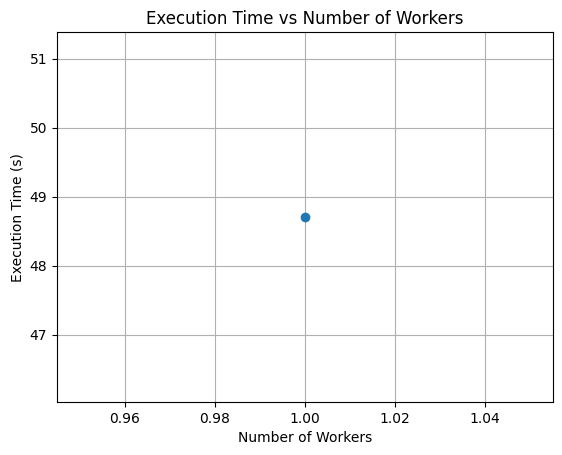

In [8]:
plt.plot(num_workers, execution_times, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Execution Time (s)')  # Label for y-axis
plt.title('Execution Time vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

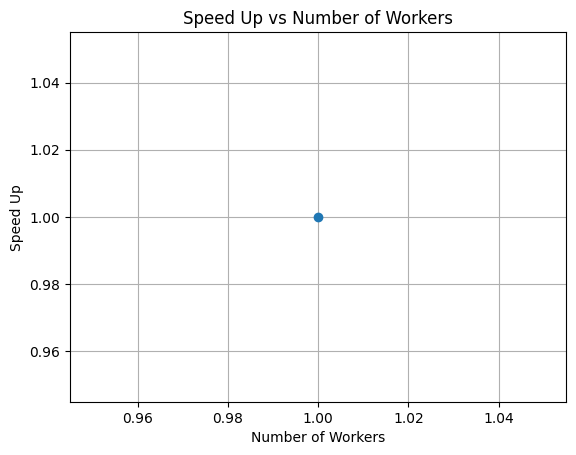

In [9]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(num_workers, speed_up, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

In [10]:
metrics_for_thresholds = compute_metrics(data_cached, weights, bias)

TP = []
FP = []
TN = []
FN = []

for threshold, metrics in metrics_for_thresholds.items():
    TP.append(metrics[0])
    FP.append(metrics[1])
    TN.append(metrics[2])
    FN.append(metrics[3])

TP = np.array(TP)
FP = np.array(FP)
TN = np.array(TN)
FN = np.array(FN)
#Accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN)
print("accuracy:", accuracy)
#Precision
precision = TP / (TP + FP)
print("precision:", precision)
#Recall
recall = TP / (TP + FN)
print("recall:", recall)
#F1
F1 = 2 * precision * recall / (precision + recall)
print("F1:", F1)
#ROC
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
plt.plot(FPR, TPR, marker='o')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()
#Precision-Recall
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

AttributeError: 'NoneType' object has no attribute 'setCallSite'